In [3]:
import numpy as np
import matplotlib.pyplot as plt

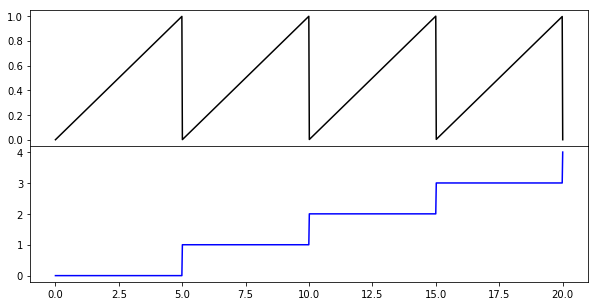

In [4]:
def getPhase(t, period):
    period_id = t // period
    t = t % period
        
    return float(t)/period, period_id


time = np.linspace(0, 20, 1000) # sec
period = 5                       # sec

phi = np.zeros(time.shape)
period_id = np.zeros(time.shape)

for i in range(len(time)):
    phi[i], period_id[i] = getPhase(time[i], period)
    

fig, axes = plt.subplots(2,1,figsize = (10,5))    
plt.subplots_adjust(hspace=0)

axes[0].plot(time, phi, color = 'black')
axes[1].plot(time, period_id, color = 'blue')

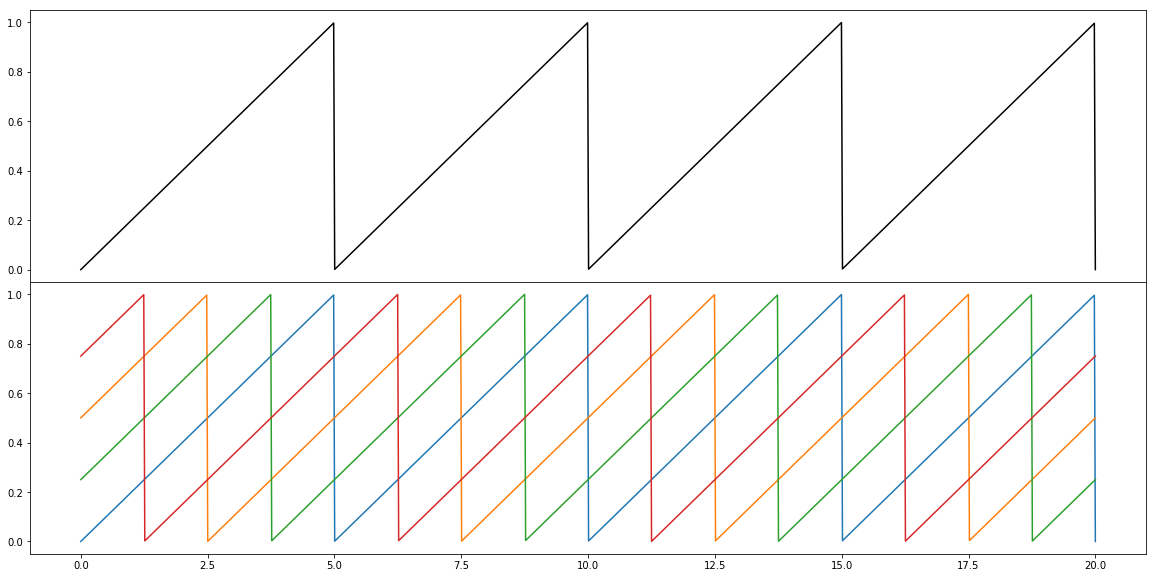

In [10]:
def getLegPhase(phase, offset):
    phase_i = phase + offset
    return phase_i % 1


time = np.linspace(0, 20, 1000) # sec
period = 5                       # sec

phi = np.zeros(time.shape)

phi_i = np.zeros([4, time.shape[0]])
offsets = [0, 0.5, 0.25, 0.75]


for i in range(len(time)):
    phi[i], _ = getPhase(time[i], period)
    for l in range(4):
        phi_i[l, i] = getLegPhase(phi[i], offsets[l])
        

fig, axes = plt.subplots(2,1,figsize = (20,10))    
plt.subplots_adjust(hspace=0)

axes[0].plot(time, phi, color = 'black')

for i in range(4):
    axes[1].plot(time, phi_i[i])

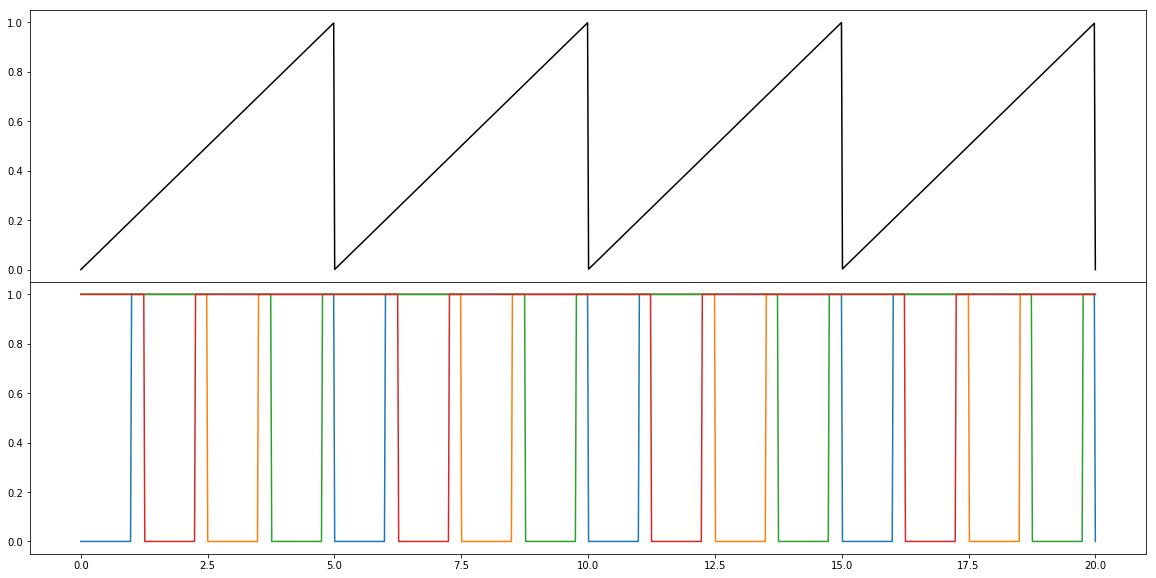

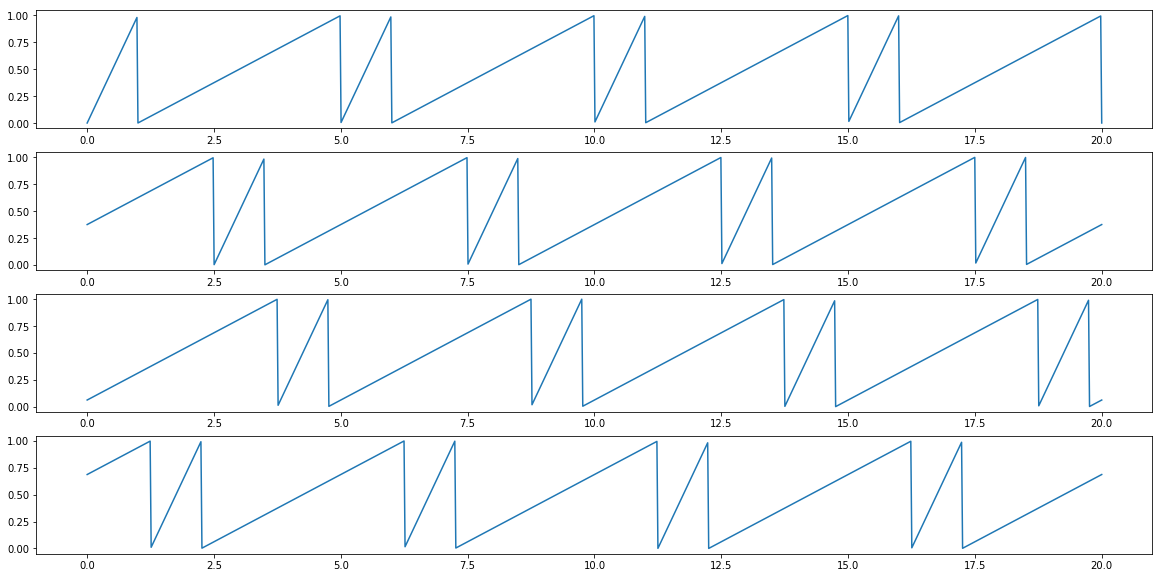

In [11]:
def getLegState(phase, offset, prop_time_swing = 0.2):
    phi_i = getLegPhase(phase, offset)
    state = 1
    if phi_i < prop_time_swing:
        state = 0
        
    if state ==0:
        state_phase = phi_i/prop_time_swing
    else:
        state_phase = (phi_i-prop_time_swing)/(1-prop_time_swing)

    return state, phi_i, state_phase

time = np.linspace(0, 20, 1000) # sec
period = 5                       # sec



phi = np.zeros(time.shape)
leg_state   = np.zeros([4, time.shape[0]])
state_phase = np.zeros([4, time.shape[0]])


for i in range(len(time)):
    phi[i], _ = getPhase(time[i], period)
    for l in range(4):
        leg_state[l, i], _, state_phase[l,i]= getLegState(phi[i], offsets[l])
        

fig, axes = plt.subplots(2,1,figsize = (20,10))    
plt.subplots_adjust(hspace=0)

axes[0].plot(time, phi, color = 'black')

for i in range(4):
    axes[1].plot(time, leg_state[i])
    
fig, axes = plt.subplots(4,1,figsize = (20,10))    
for i in range(4):
    axes[i].plot(time, state_phase[i])

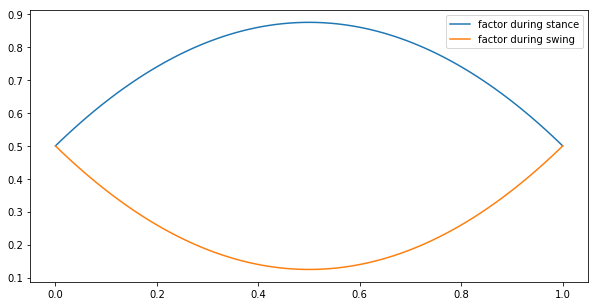

In [8]:



def getFeetWeightingFactor(leg_phase, feet_stance, sigma1 = 0.5, sigma2 = 0.5, sigma1_ = 0.5, sigma2_ = 0.5, offset = 0.5):
    #k_stance = 2*sigma*np.multiply(1-leg_phase, leg_phase)
    # This represents bezier curves
    k_stance = offset + 3*sigma1*np.multiply(np.power(1-leg_phase,2), leg_phase) + 3*sigma2*np.multiply(1-leg_phase, np.power(leg_phase, 2))
    k_stance = np.clip(k_stance, 0, 1)
    
    k_swing = offset - 3*sigma1_*np.multiply(np.power(1-leg_phase,2), leg_phase) - 3*sigma2_*np.multiply(1-leg_phase, np.power(leg_phase, 2))
    k_swing = np.clip(k_swing, 0, None)
    factor = np.multiply(feet_stance,k_stance) + np.multiply(1-feet_stance, k_swing)
    return factor




phase_stance = np.linspace(0,1,100)
factor_stance = getFeetWeightingFactor(phase_stance, True)


phase_swing = np.linspace(0,1,100)
factor_swing = getFeetWeightingFactor(phase_swing, False)

plt.subplots(figsize = (10,5))
plt.plot(phase_stance, factor_stance, label = 'factor during stance')
plt.plot(phase_swing, factor_swing, label = 'factor during swing')
plt.legend()


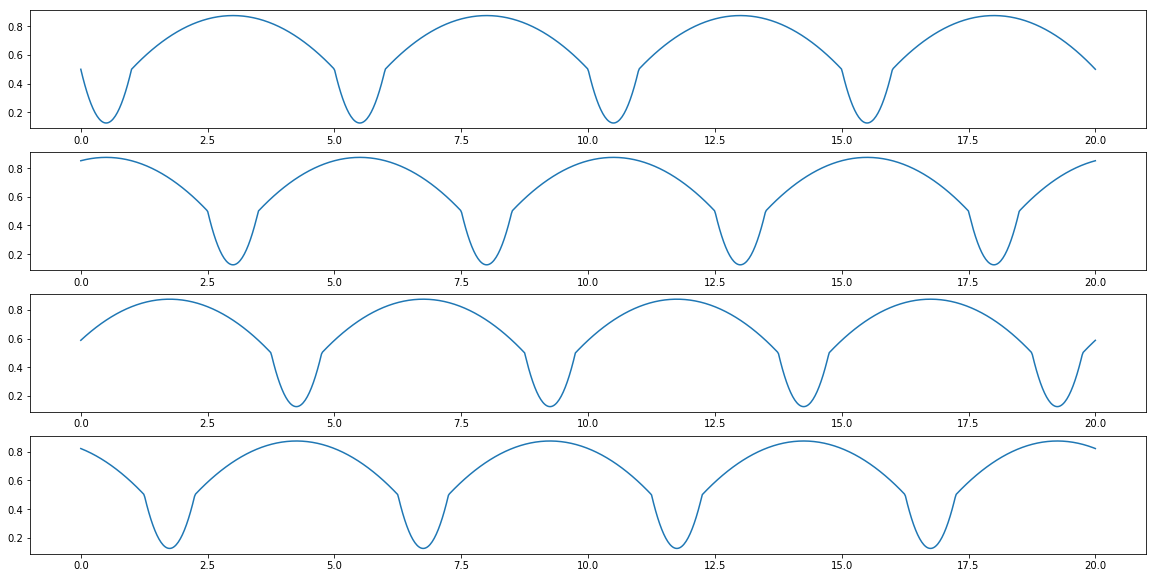

In [9]:
weight_factors = []

for i in range(4):
    weight_factors.append( getFeetWeightingFactor(state_phase[i], leg_state[i]) )
weight_factors = np.array(weight_factors)

fig, axes = plt.subplots(4,1,figsize = (20,10))    
for i in range(4):
    axes[i].plot(time, weight_factors[i])

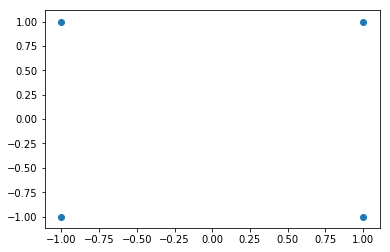

In [175]:
feet_pos_x = [1,-1, 1,-1]
feet_pos_y = [1,1,-1,-1]

plt.scatter(feet_pos_x, feet_pos_y)

feet_pos = np.vstack([feet_pos_x, feet_pos_y]).T

In [176]:
def getVirtualVertice(weight_factors, feet_pos, leg):
    pos = feet_pos[leg]
    leg_adj_1 = leg + 1
    if leg_adj_1 > 3:
        leg_adj_1 = 0
    
    leg_adj_2 = leg-1
    
    pos_adj_1 = feet_pos[leg_adj_1]
    pos_adj_2 = feet_pos[leg_adj_2]
    
    
    virtual_p_1 = weight_factors[leg]*pos + (1-weight_factors[leg])* pos_adj_1
    virtual_p_2 = weight_factors[leg]*pos + (1-weight_factors[leg])* pos_adj_2

    
    virtual_vertice = np.true_divide( weight_factors[leg]* pos + weight_factors[leg_adj_1]* virtual_p_1 + weight_factors[leg_adj_2]* virtual_p_2,  
                                     weight_factors[leg] +  weight_factors[leg_adj_1] +  weight_factors[leg_adj_2])

    return virtual_vertice


virtual_vertice_x = []
virtual_vertice_y = []

for leg in range(4):
    virtual_vertice_x.append([])
    virtual_vertice_y.append([])

    for i in range(weight_factors.shape[1]):
        v_pos = getVirtualVertice(weight_factors[:,i], feet_pos, leg)
        virtual_vertice_x[leg].append(v_pos[0])
        virtual_vertice_y[leg].append(v_pos[1])
        
virtual_vertice_x = np.array(virtual_vertice_x)
virtual_vertice_y = np.array(virtual_vertice_y)


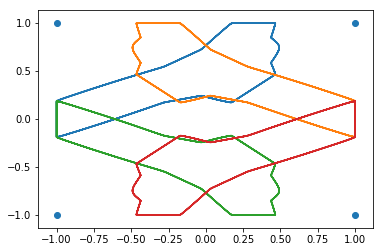

In [177]:
for i in range(4):
    plt.plot(virtual_vertice_x[i], virtual_vertice_y[i])
plt.scatter(feet_pos_x, feet_pos_y)


In [178]:
a = []

for i in range(4):
    a.append([0,1])
a = np.array(a)

a[:,0]

array([0, 0, 0, 0])

(2, 1000)


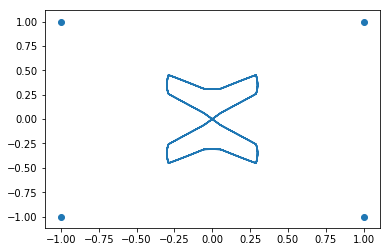

In [179]:
def getDesiredCoM(virtual_vertices_x, virtual_vertices_y):
    com_x = np.mean(virtual_vertices_x, axis = 0)
    com_y = np.mean(virtual_vertices_y, axis = 0)
    
    return np.array([com_x, com_y])



com_pos = getDesiredCoM(virtual_vertice_x, virtual_vertice_y)
print(com_pos.shape)
plt.plot(com_pos[0], com_pos[1])
plt.scatter(feet_pos_x, feet_pos_y)


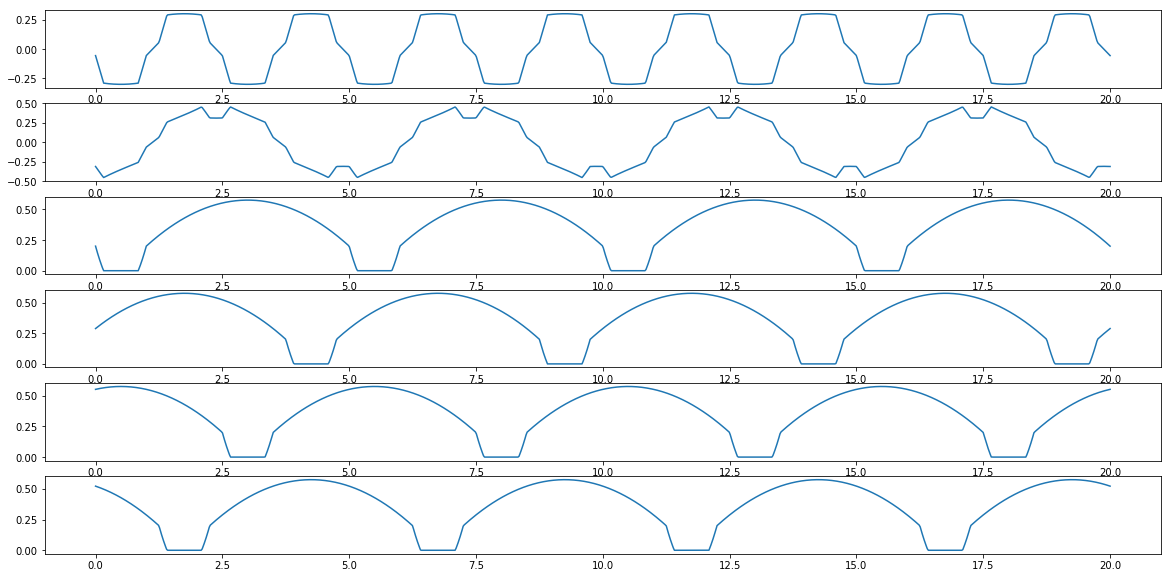

In [180]:
fig, axes = plt.subplots(6,1,figsize = (20,10))    
axes[0].plot(time, com_pos[0])
axes[1].plot(time, com_pos[1])

for i in range(4):
    axes[2+i].plot(time, weight_factors[i])